In [29]:
### Importing packages

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
%matplotlib inline

In [30]:
### Importing data
df = pd.read_csv('/Users/macbook/Desktop/Udacity/Project1/listings2.csv')
### listings is the bigger dataset 
df2 = pd.read_csv('/Users/macbook/Desktop/Udacity/Project1/reviews.csv')

## Explatory Data Analysis

### Business Understanding

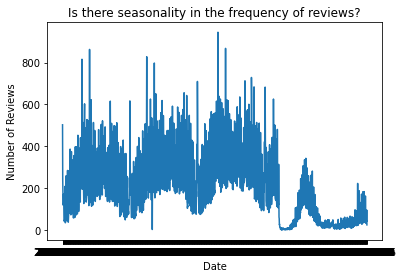

In [31]:
### Is there seasonality in the data?

pd.to_datetime(df2['date'], format='%Y-%m-%d')
#.date.strftime('%b-%d-%Y') 
df2 = df2[df2['date']>'2017-01-01']
grouped_df2 = df2.groupby(['date']).count()['id'].reset_index(name='#ofreviews')

date = grouped_df2['date']
review_volume = grouped_df2['#ofreviews']

plt.plot(date,review_volume)
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.title('Is there seasonality in the frequency of reviews?')
plt.show()

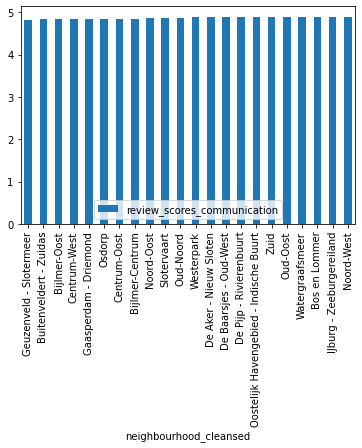

In [576]:
# lets look at how are the communication skills of different areas
# two important variables here are: 'neighbourhood_cleansed' and 'review_scores_communication'
df[['neighbourhood_cleansed', 'review_scores_communication']].isnull().sum()/df.shape[0]

# some review scores for review_scores are null. Those null review scores should not impact our analysis
# filling them with the mean of the same district to this goal
df = df.set_index(['neighbourhood_cleansed'])
df['review_scores_communication'] = df['review_scores_communication'].fillna(df['review_scores_communication'].mean())
df = df.reset_index()

# lets see the result
comm_group = df.groupby(['neighbourhood_cleansed']).mean()['review_scores_communication'].sort_values().reset_index(name='review_scores_communication')

comm_group.plot('neighbourhood_cleansed','review_scores_communication',kind='bar');

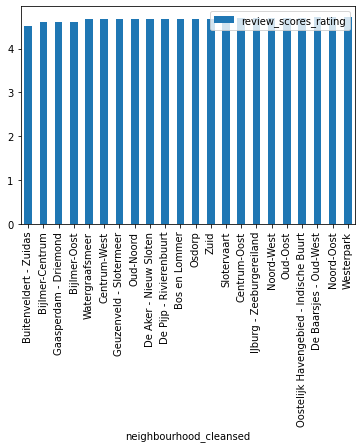

In [577]:
# how overall ratings differ among neighborhoods
df[['neighbourhood_cleansed', 'review_scores_rating']].isnull().sum()/df.shape[0]

# some review scores for review_scores are null. let's fill them with the mean of the same district
df = df.set_index(['neighbourhood_cleansed'])
df['review_scores_rating'] = df['review_scores_rating'].fillna(df['review_scores_rating'].mean())
df = df.reset_index()

# lets see the result
comm_group = df.groupby(['neighbourhood_cleansed']).mean()['review_scores_rating'].sort_values().reset_index(name='review_scores_rating')

comm_group.plot('neighbourhood_cleansed','review_scores_rating',kind='bar');

### Data Understanding and Data Preparing

In [578]:
### if 25% of the data is missing, lets drop them (11 columns)
df = df[df.columns[df.isnull().mean() < 0.25]]

In [579]:
### checking how many null values remain 
np.sum(df[df.isnull()])

neighbourhood_cleansed                            0
id                                              0.0
listing_url                                       0
scrape_id                                       0.0
last_scraped                                      0
                                               ... 
calculated_host_listings_count                  0.0
calculated_host_listings_count_entire_homes     0.0
calculated_host_listings_count_private_rooms    0.0
calculated_host_listings_count_shared_rooms     0.0
reviews_per_month                               0.0
Length: 63, dtype: object

In [522]:
# price is the response variable but it is in string format since it contains dollar sign
# so, lets get rid of the sign and convert values to float
def clean_currency(x):
    """ If the value is a string, then remove currency symbol and delimiters
    otherwise, the value is numeric and can be converted
    """
    if isinstance(x, str):
        return(x.replace('$', '').replace(',', ''))
    return(x)

df['price'] = df['price'].apply(clean_currency).astype('float')

In [523]:
### through some qualitative observation process, some variables like url information will be removed since they cannot
### be used in regression
df = df[['host_is_superhost','neighbourhood_cleansed','room_type','accommodates',
       'bathrooms_text', 'bedrooms', 'beds', 'price',
       'number_of_reviews', 'review_scores_rating', 'reviews_per_month']]

In [524]:
df.head()

host_is_superhost                  neighbourhood_cleansed        room_type  \
0                 t  Oostelijk Havengebied - Indische Buurt     Private room   
1                 f                            Centrum-Oost     Private room   
2                 t                            Centrum-West  Entire home/apt   
3                 t                            Centrum-West     Private room   
4                 t                            Centrum-Oost     Private room   

   accommodates    bathrooms_text  bedrooms  beds  price  number_of_reviews  \
0             2  1.5 shared baths       1.0   2.0   59.0                279   
1             2    1 private bath       1.0   1.0  106.0                339   
2             3            1 bath       1.0   1.0  100.0                  5   
3             2         1.5 baths       1.0   1.0  135.0                221   
4             2     1 shared bath       1.0   1.0   75.0                343   

   review_scores_rating  reviews_per_month  
0                  4.88               2.88  
1                  4.44               3.68  
2                  5.00               0.12  
3                  4.95               2.14  
4                  4.87               4.53

In [525]:
### bathroom type could be important. so a new boolean column is created.
### if the apartment has shared bathroom, the column takes TRUE value
df['bathroom_type'] = ((df['bathrooms_text'].str.find('shared') != -1) | (df['bathrooms_text'].str.find('Shared') != -1))

### replace string 'half' with numbers
df['bathrooms_text']=df['bathrooms_text'].str.replace('Half' , '0.5')
df['bathrooms_text']=df['bathrooms_text'].str.replace('half' , '0.5')

### extract numbers from text
df['bathrooms_text'] = df.bathrooms_text.str.extract('(\d+)')

### there are some outliers like 8-13 bathrooms, lets drop them
df['bathrooms_text'] = df['bathrooms_text'].astype('float')
df = df.drop(df[df.bathrooms_text > 7].index)

In [526]:
### change. boolean bathroom type to 'Shared' or 'Private'
booleandf = df.select_dtypes(include=[bool])
booleanDictionary = {True: 'Shared', False: 'Private'}
df = df.replace(booleanDictionary)

In [527]:
### if host is superhost it returns true
df['host_is_superhost'] = (df['host_is_superhost'] == 't')

In [528]:
### firstly deal with missing values. only review_scores_rating will be replaced with 0.
### Also, I'll drop reviews_per_month since we already have the similar information from number_of_reviews

#df = df.drop('reviews_per_month',1)
df = df[df['review_scores_rating'].notna()]
df = df[df['bathrooms_text'].notna()]
df = df[df['bedrooms'].notna()]
df = df[df['beds'].notna()]

In [529]:
### we dont have any null values remaining
np.sum(df.isnull())

host_is_superhost         0
neighbourhood_cleansed    0
room_type                 0
accommodates              0
bathrooms_text            0
bedrooms                  0
beds                      0
price                     0
number_of_reviews         0
review_scores_rating      0
reviews_per_month         0
bathroom_type             0
dtype: int64

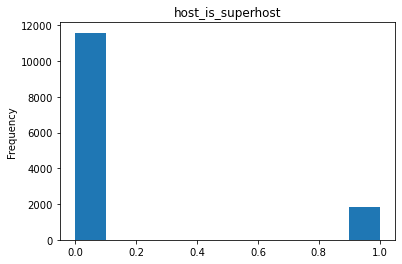

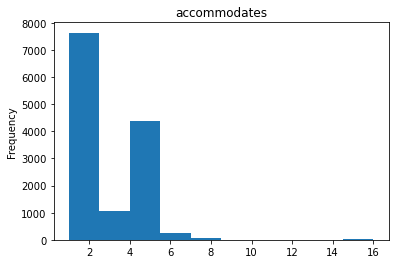

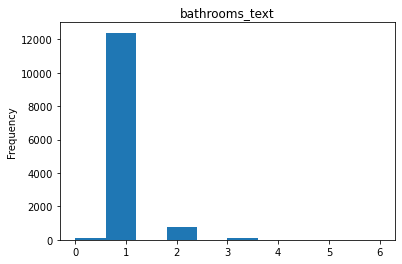

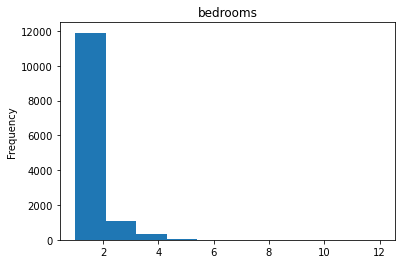

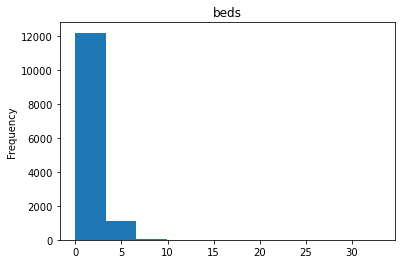

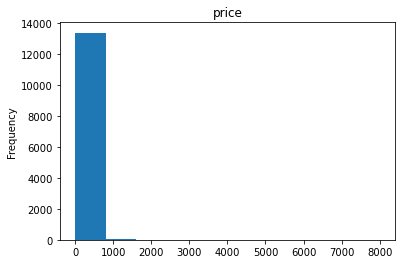

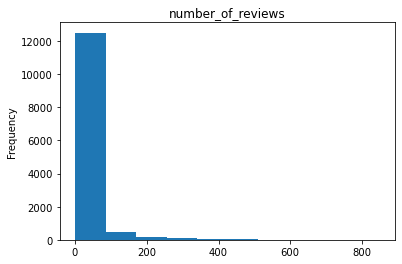

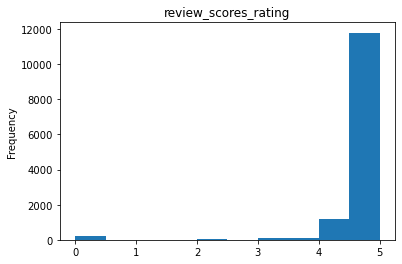

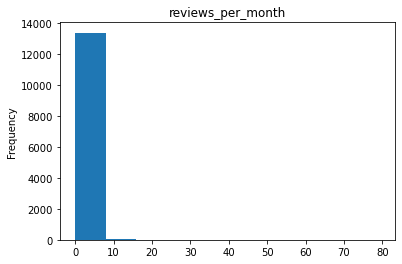

In [530]:
df['host_is_superhost'] = df['host_is_superhost'].astype('int')

### lets analyze numerics and categorical seperately
cat_df = df.select_dtypes(include=['object','bool'])
numerics_df = df.select_dtypes(include=['float', 'int'])

for cols in numerics_df:
    plt.figure(cols)
    plt.title(cols)
    numerics_df[cols].plot(kind = 'hist')

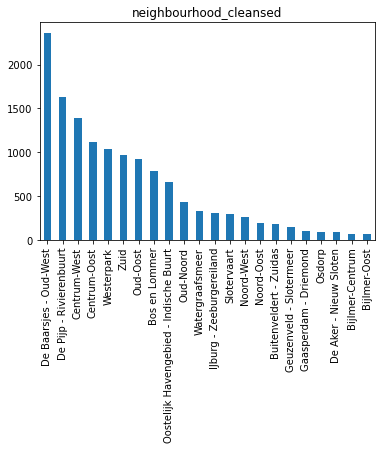

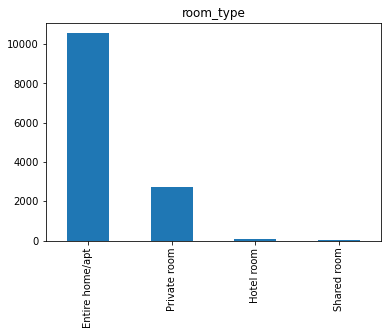

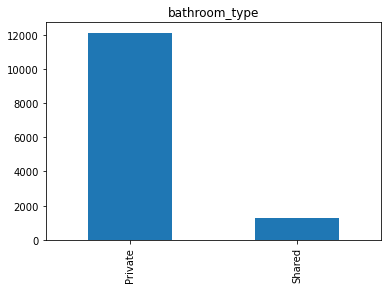

In [531]:
for cols in cat_df:
    plt.figure(cols)
    plt.title(cols)
    cat_df[cols].value_counts().plot(kind = 'bar')

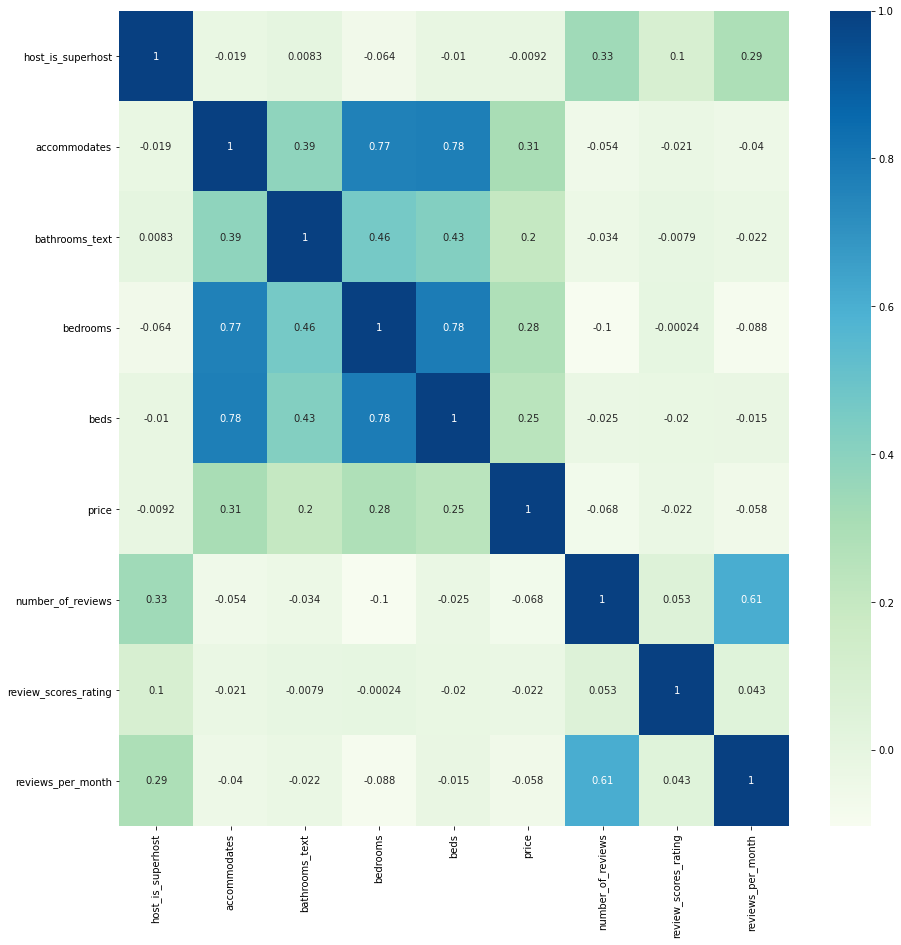

In [565]:
### we dont have a strong correlation
correlation = numerics_df.corr()
plt.figure(figsize = (15,15))
svm = sns.heatmap(correlation,cmap='GnBu',annot = True)

figure = svm.get_figure()    
figure.savefig('svm_conf.png', dpi=400)

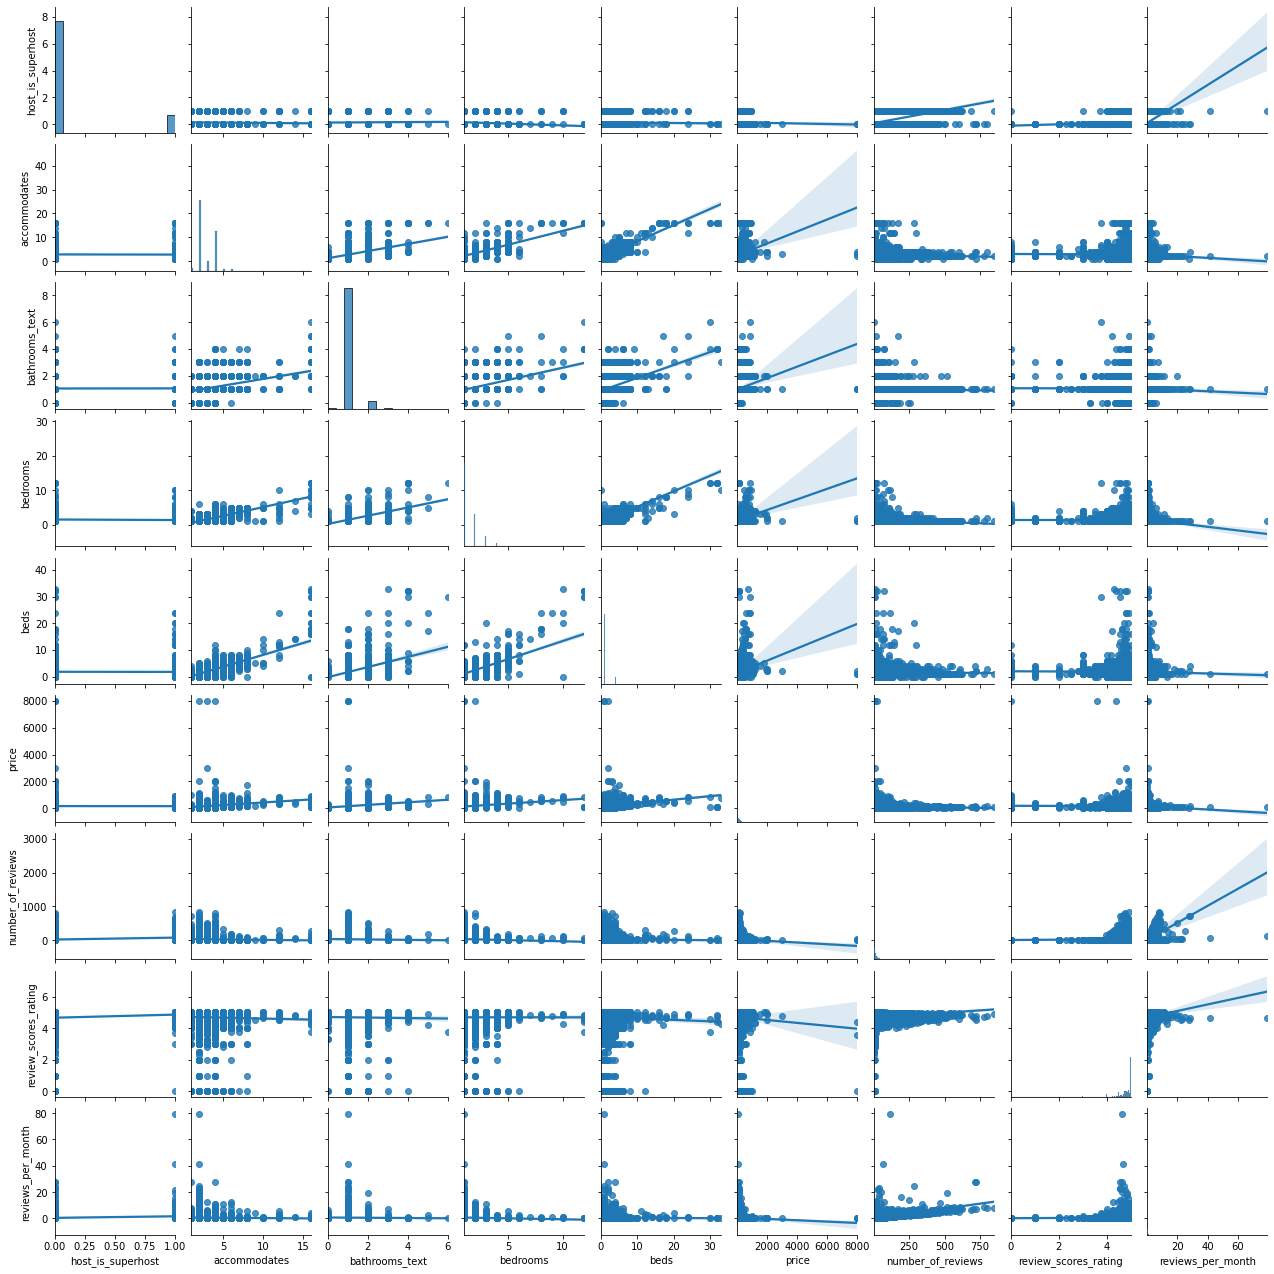

In [533]:
sns.pairplot(numerics_df,height = 2,kind ='reg');

In [534]:
# observing types of the variables
df.dtypes

host_is_superhost           int64
neighbourhood_cleansed     object
room_type                  object
accommodates                int64
bathrooms_text            float64
bedrooms                  float64
beds                      float64
price                     float64
number_of_reviews           int64
review_scores_rating      float64
reviews_per_month         float64
bathroom_type              object
dtype: object

In [535]:
# it would be better to drop groups who have little data on it compared to the other groups
df.room_type.value_counts()

Entire home/apt    10544
Private room        2747
Hotel room            86
Shared room           38
Name: room_type, dtype: int64

In [536]:
# dropping two groups from a categorical value
i = df[((df.room_type == 'Hotel room') |( df.room_type == 'Shared room') )].index
df = df.drop(i)

In [537]:
# dealing with categorical variables
cat_cols = df.select_dtypes(include=['object','bool']).columns
regres_df = pd.get_dummies(df, prefix = cat_cols, columns =cat_cols, drop_first = True )

In [538]:
regres_df.head()

host_is_superhost  accommodates  bathrooms_text  bedrooms  beds  price  \
0                  1             2             1.0       1.0   2.0   59.0   
1                  0             2             1.0       1.0   1.0  106.0   
2                  1             3             1.0       1.0   1.0  100.0   
3                  1             2             1.0       1.0   1.0  135.0   
4                  1             2             1.0       1.0   1.0   75.0   

   number_of_reviews  review_scores_rating  reviews_per_month  \
0                279                  4.88               2.88   
1                339                  4.44               3.68   
2                  5                  5.00               0.12   
3                221                  4.95               2.14   
4                343                  4.87               4.53   

   neighbourhood_cleansed_Bijlmer-Oost  ...  \
0                                    0  ...   
1                                    0  ...   
2                                    0  ...   
3                                    0  ...   
4                                    0  ...   

   neighbourhood_cleansed_Oostelijk Havengebied - Indische Buurt  \
0                                                  1               
1                                                  0               
2                                                  0               
3                                                  0               
4                                                  0               

   neighbourhood_cleansed_Osdorp  neighbourhood_cleansed_Oud-Noord  \
0                              0                                 0   
1                              0                                 0   
2                              0                                 0   
3                              0                                 0   
4                              0                                 0   

   neighbourhood_cleansed_Oud-Oost  neighbourhood_cleansed_Slotervaart  \
0                                0                                   0   
1                                0                                   0   
2                                0                                   0   
3                                0                                   0   
4                                0                                   0   

   neighbourhood_cleansed_Watergraafsmeer  neighbourhood_cleansed_Westerpark  \
0                                       0                                  0   
1                                       0                                  0   
2                                       0                                  0   
3                                       0                                  0   
4                                       0                                  0   

   neighbourhood_cleansed_Zuid  room_type_Private room  bathroom_type_Shared  
0                            0                       1                     1  
1                            0                       1                     0  
2                            0                       0                     0  
3                            0                       1                     0  
4                            0                       1                     1  

[5 rows x 32 columns]

### Data Modelling

In [539]:
X= regres_df.drop('price',axis = 1)
y = regres_df['price']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.30,random_state =42)

In [540]:
lm = LinearRegression(normalize = True)
model = lm.fit(X_train,y_train)

In [541]:
y_test_preds = lm.predict(X_test)
y_train_preds = lm.predict(X_train)

In [542]:
test_score = r2_score(y_test,y_test_preds)
train_score =r2_score(y_train,y_train_preds)
print('test score: '+str(test_score)+'train score: '+ str(train_score) )

test score: 0.12150277919828711train score: 0.15096484431014412


In [543]:
def find_optimal_lm_mod(X, y, cutoffs, test_size = .30, random_state=42, plot=True):

    r2_scores_test, r2_scores_train, num_feats, results = [], [], [], dict()
    for cutoff in cutoffs:

        #reduce X matrix
        reduce_X = X.iloc[:, np.where((X.sum() > cutoff) == True)[0]]
        num_feats.append(reduce_X.shape[1])

        #split the data into train and test
        X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

        #fit the model and obtain pred response
        lm_model = LinearRegression(normalize=True)
        lm_model.fit(X_train, y_train)
        y_test_preds = lm_model.predict(X_test)
        y_train_preds = lm_model.predict(X_train)

        #append the r2 value from the test set
        r2_scores_test.append(r2_score(y_test, y_test_preds))
        r2_scores_train.append(r2_score(y_train, y_train_preds))
        results[str(cutoff)] = r2_score(y_test, y_test_preds)

    if plot:
        plt.plot(num_feats, r2_scores_test, label="Test", alpha=.5)
        plt.plot(num_feats, r2_scores_train, label="Train", alpha=.5)
        plt.xlabel('Number of Features')
        plt.ylabel('Rsquared')
        plt.title('Rsquared by Number of Features')
        plt.legend(loc=1)
        plt.show()

    best_cutoff = max(results, key=results.get)

    #reduce X matrix
    reduce_X = X.iloc[:, np.where((X.sum() > int(best_cutoff)) == True)[0]]
    num_feats.append(reduce_X.shape[1])

    #split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

    #fit the model
    lm_model = LinearRegression(normalize=True)
    lm_model.fit(X_train, y_train)

    return r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test

### Evaluating Results

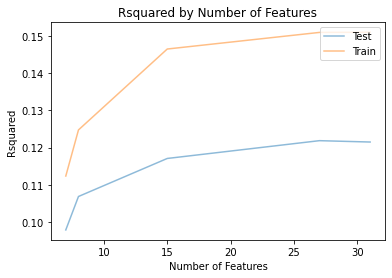

In [544]:
cutoffs = [5000, 3500, 2500, 1000, 100, 50, 30, 25]

r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test = find_optimal_lm_mod(X, y, cutoffs)

In [564]:
def coef_weights(coefficients, X_train):
    
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('coefs', ascending=True)
    return coefs_df


coef_df = coef_weights(lm_model.coef_, X_train)
coef_df.sort_values('coefs', ascending=True)

est_int      coefs  abs_coefs
25                             room_type_Private room -37.538735  37.538735
26                               bathroom_type_Shared -15.744131  15.744131
6                                review_scores_rating  -8.594643   8.594643
17                  neighbourhood_cleansed_Noord-West  -5.695504   5.695504
4                                                beds  -4.223533   4.223533
16                  neighbourhood_cleansed_Noord-Oost  -3.254402   3.254402
7                                   reviews_per_month  -1.674943   1.674943
5                                   number_of_reviews  -0.061790   0.061790
15    neighbourhood_cleansed_IJburg - Zeeburgereiland   5.539656   5.539656
21                 neighbourhood_cleansed_Slotervaart   7.584372   7.584372
8                neighbourhood_cleansed_Bos en Lommer  11.136665  11.136665
19                   neighbourhood_cleansed_Oud-Noord  13.583299  13.583299
0                                   host_is_superhost  13.862715  13.862715
9       neighbourhood_cleansed_Buitenveldert - Zuidas  14.272908  14.272908
14     neighbourhood_cleansed_Geuzenveld - Slotermeer  19.483616  19.483616
22             neighbourhood_cleansed_Watergraafsmeer  21.993013  21.993013
3                                            bedrooms  23.095918  23.095918
1                                        accommodates  23.202041  23.202041
20                    neighbourhood_cleansed_Oud-Oost  23.912805  23.912805
18  neighbourhood_cleansed_Oostelijk Havengebied -...  24.390974  24.390974
2                                      bathrooms_text  31.169622  31.169622
12      neighbourhood_cleansed_De Baarsjes - Oud-West  36.693675  36.693675
23                  neighbourhood_cleansed_Westerpark  37.624407  37.624407
24                        neighbourhood_cleansed_Zuid  46.956461  46.956461
13     neighbourhood_cleansed_De Pijp - Rivierenbuurt  50.435000  50.435000
10                neighbourhood_cleansed_Centrum-Oost  63.577575  63.577575
11                neighbourhood_cleansed_Centrum-West  84.897967  84.897967